In [1]:
%matplotlib inline

In [2]:
import dipy.reconst.dti as dti

import os
import numpy as np
import math
import SimpleITK as sitk
from scipy import ndimage
import nibabel as nib
from PIL import Image
import scipy.misc
from scipy import signal
import warnings
import SimpleITK as sitk
from dipy.reconst.dti import *

In [17]:
from ndreg import *
from dipy.tracking.eudx import EuDX

In [4]:
def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :], 90)
            else:
                image = im[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig

def tiff_to_array(folder_path, input_path):
    """
    Function takes a single image (TIFF, or other also works), and returns
    the single image as a numpy array.  Called by tiff_stack_to_array.
    :param input_path: Single image file to open.
    :return: Numpy representation of image.
    """

    # The convert tag makes sure that we're dealing with floats, not uint8
    # This prevents underflow.
    im = Image.open(folder_path + input_path).convert("F")
    # im.show()

    imarray = np.array(im)
    # print(imarray)
    # print(imarray.dtype)
    
    return imarray


def tiff_stack_to_array(input_path):
    """
    Function takes input_path, which should should lead to a directory.
    Loads all TIFFs in input_path, then generates numpy arrays from the
    TIFF stack by calling tiff_to_array helper function.  Make sure TIFF
    images are ordered in numerical order.
    :param input_path: Folder or directory containing .tiff stack.
    :return: Numpy array of tiff stack.
    """
    im_list = [];
    for filename in os.listdir(input_path):
        if filename.endswith(".tif"):
            # print(os.path.join(directory, filename))
            im_arr = tiff_to_array(input_path, filename)
            im_list.append(im_arr)
        
    s = np.stack(im_list, axis=2)
    print s.shape
    return s

In [5]:
# A Python implementation of Ailey's matlab tensor code.

import os
import numpy as np
import math
import SimpleITK as sitk
from scipy import ndimage
import nibabel as nib
from PIL import Image
import scipy.misc
from scipy import signal
import warnings

#warnings.filterwarnings("ignore")

def doggen(sigma):
    """
    Helper function to generate derivatives of Gaussian kernels, in either 1D, 2D, or 3D.
    Source code in MATLAB obtained from Qiyuan Tian, Stanford University, September 2015
    :param sigma: Sigma for use (see defaults in generate_FSL_structure_tensor)
    :return: Derivative of Gaussian kernel with dimensions of sigma.
    """
    halfsize = np.ceil(3 * np.max(sigma))
    x = range(np.single(-halfsize), np.single(halfsize + 1));  # Python colon is not inclusive at end, while MATLAB is.
    dim = len(sigma);
    
    if dim == 1:
        X = np.array(x);  # Remember that, by default, numpy arrays are elementwise multiplicative
        X = X.astype(float);
        k = -X * np.exp(-X**2/(2 * sigma**2));
        
    elif dim == 2:
        [X, Y] = np.meshgrid(x, x);
        X = X.astype(float);
        Y = Y.astype(float);
        k = -X * np.exp(-X**2/(2*sigma[0]^2) * np.exp(-Y**2))
        
    elif dim == 3:
        [X, Y, Z] = np.meshgrid(x, x, x);
        X = X.transpose(0, 2, 1);  # Obtained through vigorous testing (see below...)
        Y = Y.transpose(2, 0, 1);
        Z = Z.transpose(2, 1, 0);
        
        X = X.astype(float);
        Y = Y.astype(float);
        Z = Z.astype(float);
        k = -X * np.exp(np.divide(-np.power(X, 2), 2 * np.power(sigma[0], 2))) * np.exp(np.divide(-np.power(Y,2), 2 * np.power(sigma[1],2))) * np.exp(np.divide(-np.power(Z,2), 2 * np.power(sigma[2],2)))
        
    else:
        print 'Only supports up to 3 dimensions'
        
    return np.divide(k, np.sum(np.abs(k[:])));

def gaussgen(sigma):
    """
    Function to generate Gaussian kernels, in 1D, 2D and 3D.
    Source code in MATLAB obtained from Qiyuan Tian, Stanford University, September 2015
    :param sigma: Sigma for use in generating Gaussian kernel (see defaults in generate_FSL_structure_tensor)
    :return: Gaussian kernel with dimensions of sigma.
    """
    halfsize = np.ceil(3 * max(sigma));
    x = range(np.single(-halfsize), np.single(halfsize + 1));

    dim = len(sigma);

    if dim == 1:
        x = x.astype(float);
        k = np.exp(-x**2 / (2 * sigma^2));
    
    elif dim == 2:
        [X, Y] = np.meshgrid(x, x);
        X = X.astype(float);
        Y = Y.astype(float);
        
        k = np.exp(-X**2 / (2 * sigma[0]**2)) * np.exp(-Y**2 / (2 * sigma[1]**2)); 
    
    elif dim == 3:
        [X, Y, Z] = np.meshgrid(x, x, x);
        X = X.transpose(0, 2, 1);  # Obtained through vigorous testing (see below...)
        Y = Y.transpose(2, 0, 1);
        Z = Z.transpose(2, 1, 0);
        
        X = X.astype(float);
        Y = Y.astype(float);
        Z = Z.astype(float);
        k = np.exp(-X**2 / (2 * sigma[0]**2)) * np.exp(-Y**2 / (2 * sigma[1]**2)) * np.exp(-Z**2 / (2 * sigma[2]**2));
    
    else:
        print 'Only supports up to dimension 3'

    return np.divide(k, np.sum(np.abs(k)));


def tiff_to_array(folder_path, input_path):
    """
    Function takes a single image (TIFF, or other also works), and returns
    the single image as a numpy array.  Called by tiff_stack_to_array.
    :param input_path: Single image file to open.
    :return: Numpy representation of image.
    """

    # The convert tag makes sure that we're dealing with floats, not uint8
    # This prevents underflow.
    im = Image.open(folder_path + input_path).convert("F")
    # im.show()

    imarray = np.array(im)
    # print(imarray)
    # print(imarray.dtype)
    
    return imarray


def tiff_stack_to_array(input_path):
    """
    Function takes input_path, which should should lead to a directory.
    Loads all TIFFs in input_path, then generates numpy arrays from the
    TIFF stack by calling tiff_to_array helper function.  Make sure TIFF
    images are ordered in numerical order.
    :param input_path: Folder or directory containing .tiff stack.
    :return: Numpy array of tiff stack.
    """
    im_list = [];
    for filename in os.listdir(input_path):
        if filename.endswith(".tiff"):
            # print(os.path.join(directory, filename))
            im_arr = tiff_to_array(input_path, filename)
            im_list.append(im_arr)
        
    s = np.stack(im_list, axis=2)
    print s.shape
    return s

def nii_to_tiff_stack(input_path, token):
    """
    Function loads an nii using SITK, then converts the nii into a folder containing a TIFF stack.
    This function is useful later on for generating the structure tensor.
    :param input_path: Path to .nii file.
    :param token: Name of token.
    """

    image = sitk.ReadImage(input_path);

    planes_number = image.GetSize();
    data = sitk.GetArrayFromImage(image)
    z_dimension = planes_number[2];

    ## if we have (i, j, k), we want (k, j, i)  (converts nibabel format to sitk format)
    ##new_im = aut_1367.swapaxes(0,2) # just swap i and k

    if not os.path.exists(token + "_TIFFs"):
        os.makedirs(token + "_TIFFs");

    plane = 0;

    for plane in range(0, z_dimension):
        output = data[plane, :, :]
        scipy.misc.toimage(output).save(token + "_TIFFs/" + token + "_" + str(plane) + '.tiff')

def generate_FSL_structure_tensor(img_data, filename, dogsigmaArr=[1], gausigmaArr=[2.3], angleArr=[25]):
    """
    Function takes a numpy array (from TIFF_stack_to_array) and saves output
    FSL structure tensor as filename string. Allows inputting alternate dogsigmaArr,
    gausigmaArr, angleArr, although defaults to currently to parameters from MATLAB script.
    Also returns tensorfsl (the tensor fsl structure) image numpy array.

    ## Parameters (the script loops through all parameters and saves each result automatically)
    # dogsigmaArr = [1]; Sigma values for derivative of gaussian filter, recommended value: 0.6 - 1.3 (based on actual data)
    # gausigmaArr = [2.3]; Sigma values for gaussian filter, recommended value: 1.3 - 2.3 (based on actual data)
    # angleArr = [25]; Angle thresholds for fiber tracking, recommended value: 20 - 30.

    Follows code from MATLAB CAPTURE scripts.

    :param img_data: Numpy array of image, typically from tiff_stack_to_array called on a directory of TIFFs.
    :param filename: Name to save the FSL structure tensor as.
    :param dogsigmaArr: Sigma values for derivative of Gaussian filter, with recommended values between 0.6 - 1.3.
    :param gausigmaArr: Sigma values for Gaussian filter, with recommended values between 1.3 - 2.3.
    :param angleArr: Angle threshold for fiber tracking, with recommended values between 20 - 30.
    :return tensorfsl: TensorFSL format of structure tensor (upper triangular matrix)
    """
    for jj in range(len(dogsigmaArr)):
        dogsigma = dogsigmaArr[jj];
        print "Start DoG Sigma on " + str(dogsigma);

        # Generate dog kernels
        dogkercc = doggen([dogsigma, dogsigma, dogsigma]);
        dogkercc = np.transpose(dogkercc, (0, 2, 1));  # annoying

        #print dogkercc.shape;
        #print dogkercc[:, :, 0];

        dogkerrr = np.transpose(dogkercc, (1, 0, 2));

        #print dogkerrr[:, :, 0];
        dogkerzz = np.transpose(dogkercc, (0, 2, 1));

        #print dogkerzz[:, :, 0];

        # Compute gradients
        grr = signal.convolve(img_data, dogkerrr, 'same');

        #print grr[:, :, 0];

        gcc = signal.convolve(img_data, dogkercc, 'same');

        #print gcc[:, :, 0];

        gzz = signal.convolve(img_data, dogkerzz, 'same');

        #print gzz[:, :, 0];

        # Compute gradient products
        gprrrr = np.multiply(grr, grr);

        #print gprrrr[:, :, 0];

        gprrcc = np.multiply(grr, gcc);

        #print gprrcc[:, :, 0];

        gprrzz = np.multiply(grr, gzz);

        #print gprrzz[:, :, 0]

        gpcccc = np.multiply(gcc, gcc);
        gpcczz = np.multiply(gcc, gzz);
        gpzzzz = np.multiply(gzz, gzz);

        # Compute gradient amplitudes
        # print ga.dtype;
        ga = np.sqrt(gprrrr + gpcccc + gpzzzz);

        #print ga[:, :, 0];

        #print "GA SHAPE:"
        #print ga.shape;

        # Convert numpy ndarray object to Nifti data type
        gradient_amplitudes_data = nib.Nifti1Image(ga, affine=np.eye(4));

        # Save gradient amplitudes image 
        nib.save(gradient_amplitudes_data, 'gradient_amplitudes.nii');

        # Compute gradient vectors
        gv = np.concatenate((grr[..., np.newaxis], gcc[..., np.newaxis], gzz[..., np.newaxis]), axis = 3);
        
        #print gv[:, :, 0, 0];
        
        gv = np.divide(gv, np.tile(ga[..., None], [1, 1, 1, 3]));
        #print gv[:, :, 0, 1];

        #print "GV SHAPE:"
        #print gv.shape;

        # Convert numpy ndarray object to Nifti data type
        gradient_vectors_data = nib.Nifti1Image(gv, affine=np.eye(4));

        # Save gradient vectors
        nib.save(gradient_vectors_data, 'gradient_vectors.nii');

        # Compute structure tensor
        for kk in range(len(gausigmaArr)):
            gausigma = gausigmaArr[kk];
            print "Start Gauss Sigma with gausigma = " + str(gausigma);

            print "Generating Gaussian kernel..."
            gaussker = np.single(gaussgen([gausigma, gausigma, gausigma]));

            #print gaussker[:, :, 0];

            print "Blurring gradient products..."
            gprrrrgauss = signal.convolve(gprrrr, gaussker, "same");
            
            #print gprrrrgauss[:, :, 0];
            
            gprrccgauss = signal.convolve(gprrcc, gaussker, "same");
            
            #print gprrccgauss[:, :, 0];
            
            gprrzzgauss = signal.convolve(gprrzz, gaussker, "same");
            gpccccgauss = signal.convolve(gpcccc, gaussker, "same");
            gpcczzgauss = signal.convolve(gpcczz, gaussker, "same");
            gpzzzzgauss = signal.convolve(gpzzzz, gaussker, "same");

            print "Saving a copy for this Gaussian sigma..."
            tensorfsl = np.concatenate((gprrrrgauss[..., np.newaxis], gprrccgauss[..., np.newaxis], gprrzzgauss[..., np.newaxis], gpccccgauss[..., np.newaxis], gpcczzgauss[..., np.newaxis], gpzzzzgauss[..., np.newaxis]), axis = 3);
            tmp = np.copy(tensorfsl[:,:,:,3])
            tensorfsl[:,:,:,3] = tensorfsl[:,:,:,2]
            tensorfsl[:,:,:,2] = tmp
             # Convert numpy ndarray object to Nifti data type
            tensor_fsl_data = nib.Nifti1Image(tensorfsl, affine=np.eye(4));

            nib.save(tensor_fsl_data, str(filename) + "dogsigma_" + str(jj) + "gausigma_" + str(kk) + 'tensorfsl.nii');

    print 'Completed computing structure tensor on ' + str(filename) + '!'
    return tensorfsl


def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :,0:3], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :,0:3], 90)
            else:
                image = im[:, :, pos,0:3]

            print image.shape
            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig


def fiber_stream(f):
    test = f
    print len(test)
    fig = plt.figure(1)
    plt.subplots(figsize=(10, 10))
    plt.subplot(311)
    plt.title("Y-axis vs X-axis (" + str(len(test)) + " fibers)")
    for i in range(len(test)):
        plt.plot(test[i][:,0], test[i][:,1])
    plt.subplot(312)
    plt.title("Z-axis vs X-axis (" + str(len(test)) + " fibers)")
    for i in range(len(test)):
        plt.plot(test[i][:,0], test[i][:,2])
    plt.subplot(313)
    plt.title("Z-axis vs Y-axis (" + str(len(test)) + " fibers)")
    for i in range(len(test)):
        plt.plot(test[i][:,1], test[i][:,2])
    plt.tight_layout()
    #fig = plt.show()
    fig.savefig('tensor_streamlines.png')


def tensor2tract(struct_tensor, is_fsl):
    if is_fsl:
        tmp = np.copy(struct_tensor[:,:,:,3])
        struct_tensor[:,:,:,3] = struct_tensor[:,:,:,2]
        struct_tensor[:,:,:,2] = tmp
    output = from_lower_triangular(struct_tensor)

    evals, evecs = decompose_tensor(output)

    FA = fractional_anisotropy(evals)

    RGB = color_fa(FA, evecs)
    # nb.save(nb.Nifti1Image(np.array(255 * RGB, 'uint8'), result.get_affine()), 'fsl_tensor_rgb_upper.nii.gz')

    affine = img.get_affine()
    fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
    im = fa.get_data()

    fig = plot_rgb(im)
    plt.savefig('tensor_field_brain.png')


    sphere = get_sphere('symmetric724')
    peak_indices = quantize_evecs(evecs, sphere.vertices)
    eu = EuDX(FA.astype('f8'), peak_indices, seeds=50000, odf_vertices = sphere.vertices, a_low=0.2)
    tensor_streamlines = [streamline for streamline in eu]
    return tensor_streamlines

In [7]:
def generate_FSL_and_DTK_structure_tensor_test(img_data, filename, dogsigmaArr=[1], gausigmaArr=[0.5], angleArr=[25]):
    """
    Function takes a numpy array (from TIFF_stack_to_array) and saves output
    FSL/DTK structure tensors as filename string. Allows inputting alternate dogsigmaArr,
    gausigmaArr, angleArr, although defaults to currently to parameters from MATLAB script.
    Also returns tensorfsl / tensorDTK (the tensor fsl/DTK structure) image numpy arrays.

    ## Parameters (the script loops through all parameters and saves each result automatically)
    # dogsigmaArr = [1]; Sigma values for derivative of gaussian filter, recommended value: 0.6 - 1.3 (based on actual data)
    # gausigmaArr = [2.3]; Sigma values for gaussian filter, recommended value: 1.3 - 2.3 (based on actual data)
    # angleArr = [25]; Angle thresholds for fiber tracking, recommended value: 20 - 30.

    Follows code from MATLAB CAPTURE scripts.

    :param img_data: Numpy array of image, typically from tiff_stack_to_array called on a directory of TIFFs.
    :param filename: Name to save the FSL structure tensor as.
    :param dogsigmaArr: Sigma values for derivative of Gaussian filter, with recommended values between 0.6 - 1.3.
    :param gausigmaArr: Sigma values for Gaussian filter, with recommended values between 1.3 - 2.3. (?)
    :param angleArr: Angle threshold for fiber tracking, with recommended values between 20 - 30. (?)
    :return tensorfsl: TensorFSL format of structure tensor (upper triangular matrix)
    :return tensordtk: TensorDTK format of structure tensor (upper triangular matrix)
    """
    
    # Helper function similar to MATLAB
    def cropvol(vol, sz):
        print np.size(vol);
        vol[0:sz, :, :, :] = 0;
        vol[-1-sz+1:-1, :, :, :] = 0;

        vol[:, 0:sz, :, :] = 0;
        vol[:, -1-sz+1:-1, :, :] = 0;

        vol[:, :, 0:sz, :] = 0;
        vol[:, :, -1-sz+1:-1, :] = 0;
        return vol;
    
    for ii in range(len(dogsigmaArr)):
        dogsigma = dogsigmaArr[ii];
        print "Start DoG Sigma on " + str(dogsigma);

        # Generate dog kernels
        dogkercc = doggen([dogsigma, dogsigma, dogsigma]);
        dogkercc = np.transpose(dogkercc, (0, 2, 1));  # annoying

        #print dogkercc.shape;
        print dogkercc[:, :, 0];

        dogkerrr = np.transpose(dogkercc, (1, 0, 2));

        #print dogkerrr[:, :, 0];
        dogkerzz = np.transpose(dogkercc, (0, 2, 1));

        #print dogkerzz[:, :, 0];

        for jj in range(len(gausigmaArr)):
            gausigma = gausigmaArr[jj];
  
            print "Start Gauss Sigma with gausigma = " + str(gausigma);

            print "Generating Gaussian kernel..."
            gaussker = np.single(gaussgen([gausigma, gausigma, gausigma]));

            # Generate half size kernel
            halfsz = (max(len(dogkercc), len(gaussker)) + 1) / 2;

            # Compute gradients
            grr = signal.convolve(img_data, dogkerrr, 'same');

            #print grr[:, :, 0];

            gcc = signal.convolve(img_data, dogkercc, 'same');

            #print gcc[:, :, 0];

            gzz = signal.convolve(img_data, dogkerzz, 'same');

            #print gzz[:, :, 0];

            # Compute gradient products
            gprrrr = np.multiply(grr, grr);

            #print gprrrr[:, :, 0];

            gprrcc = np.multiply(grr, gcc);

            #print gprrcc[:, :, 0];

            gprrzz = np.multiply(grr, gzz);

            #print gprrzz[:, :, 0]

            gpcccc = np.multiply(gcc, gcc);
            gpcczz = np.multiply(gcc, gzz);
            gpzzzz = np.multiply(gzz, gzz);

            # Compute gradient amplitudes
            # print ga.dtype;
            ga = np.sqrt(gprrrr + gpcccc + gpzzzz);

            #print ga[:, :, 0];

            #print "GA SHAPE:"
            #print ga.shape;

            # Convert numpy ndarray object to Nifti data type
            gradient_amplitudes_data = nib.Nifti1Image(ga, affine=np.eye(4));

            # Save gradient amplitudes image 
            nib.save(gradient_amplitudes_data, 'gradient_amplitudes.nii.gz');

            # Compute gradient vectors
            gv = np.concatenate((grr[..., np.newaxis], gcc[..., np.newaxis], gzz[..., np.newaxis]), axis = 3);
            
            #print gv[:, :, 0, 0];
            
            gv = np.divide(gv, np.tile(ga[..., None], [1, 1, 1, 3]));
            #print gv[:, :, 0, 1];

            #print "GV SHAPE:"
            #print gv.shape;

            # Convert numpy ndarray object to Nifti data type
            gradient_vectors_data = nib.Nifti1Image(gv, affine=np.eye(4));

            # Save gradient vectors
            nib.save(gradient_vectors_data, 'gradient_vectors.nii.gz');

            #print gaussker[:, :, 0];

            print "Blurring gradient products..."
            gprrrrgauss = signal.convolve(gprrrr, gaussker, "same");
            
            #print gprrrrgauss[:, :, 0];
            
            gprrccgauss = signal.convolve(gprrcc, gaussker, "same");
            
            #print gprrccgauss[:, :, 0];
            
            gprrzzgauss = signal.convolve(gprrzz, gaussker, "same");
            gpccccgauss = signal.convolve(gpcccc, gaussker, "same");
            gpcczzgauss = signal.convolve(gpcczz, gaussker, "same");
            gpzzzzgauss = signal.convolve(gpzzzz, gaussker, "same");

            print "Saving a copy for this Gaussian sigma..."
            tensorfsl = np.concatenate((gprrrrgauss[..., np.newaxis], gprrccgauss[..., np.newaxis], gprrzzgauss[..., np.newaxis], gpccccgauss[..., np.newaxis], gpcczzgauss[..., np.newaxis], gpzzzzgauss[..., np.newaxis]), axis = 3);
            
            tensordtk = np.concatenate((gprrrrgauss[..., np.newaxis], gprrccgauss[..., np.newaxis], gpccccgauss[..., np.newaxis], gprrzzgauss[..., np.newaxis], gpcczzgauss[..., np.newaxis], gpzzzzgauss[..., np.newaxis]), axis = 3);

             # Convert numpy ndarray object to Nifti data type
            tensor_fsl_data = nib.Nifti1Image(cropvol(tensorfsl, halfsz), affine=np.eye(4));
            tensor_dtk_data = nib.Nifti1Image(cropvol(tensordtk, halfsz), affine=np.eye(4));

            nib.save(tensor_fsl_data, str(filename) + "dogsigma_" + str(dogsigma) + "gausigma_" + str(gausigma) + 'tensorfsl.nii.gz');
            nib.save(tensor_dtk_data, str(filename) + "dogsigma_" + str(dogsigma) + "gausigma_" + str(gausigma) + 'tensordtk.nii.gz');

    print 'Completed computing structure tensor on ' + str(filename) + '!'
    return tensorfsl, tensordtk

# Step 1 registration

In [8]:
img = nib.load('Fear199.img')

In [9]:
rawImg = imgRead('Fear199.img')

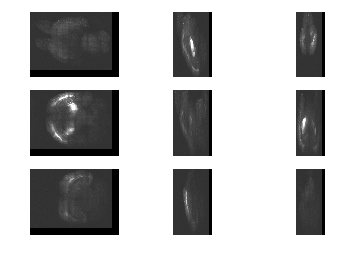

In [11]:
inThreshold = imgPercentile(rawImg, 0.99)
imgShow(rawImg, vmax=500)

In [10]:
annoimg = nib.load('Fear199ImageLddmmABALabels.img')

In [11]:
rawanno = imgRead('Fear199ImageLddmmABALabels.img')

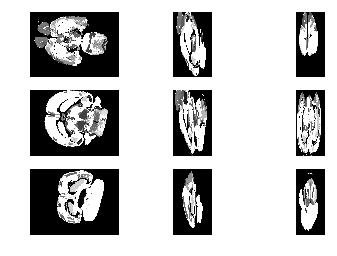

In [14]:
inThreshold = imgPercentile(rawanno, 0.99)
imgShow(rawanno, vmax=500)

In [15]:
format_img = img.get_data()[:,:,:,0]

In [16]:
fear199tensor = generate_FSL_structure_tensor(format_img, filename = 'fear199tensor', dogsigmaArr=[1], gausigmaArr=[2.3], angleArr=[25])

Start DoG Sigma on 1


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:249: RuntimeWarning: invalid value encountered in divide


Start Gauss Sigma with gausigma = 2.3
Generating Gaussian kernel...
Blurring gradient products...
Saving a copy for this Gaussian sigma...
Completed computing structure tensor on fear199tensor!


In [17]:
np.save('tensorimage',fear199tensor)

In [7]:
#tensorimg = fear199tensor
tensorimg = np.load('tensorimage.npy')

In [8]:
print tensorimg.shape

(768, 576, 1358, 6)


In [9]:
data = tensorimg
print data.shape

(768, 576, 1358, 6)


In [10]:
output = from_lower_triangular(data)
print output.shape

(768, 576, 1358, 3, 3)


In [21]:
output_ds = output[300:500, 250:350, 400:800, :, :]
print output_ds.shape

(200, 100, 400, 3, 3)


In [12]:
FA = fractional_anisotropy(output_ds)
FA = np.clip(FA, 0, 1)
FA[np.isnan(FA)] = 0
print FA.shape

(200, 100, 400, 3)


/usr/local/lib/python2.7/dist-packages/dipy/reconst/dti.py:108: RuntimeWarning: invalid value encountered in sqrt
  ((evals * evals).sum(0) + all_zero))


In [6]:
#np.save('fa', FA)
FA = np.load('fa.npy')

In [ ]:
ls

In [13]:
evalues, evectors = decompose_tensor(output_ds)
print evectors[..., 0, 0].shape
print evectors.shape[-2:]

(200, 100, 400)
(3, 3)


In [14]:
RGB = color_fa(FA[:, :, :, 0], evectors)

In [ ]:
np.save('rgb', RGB)

In [180]:
#nib.save(img, "affineimgalberuutu.nii")

In [181]:
#nib.save(nib.Nifti1Image(np.array(255 * RGB, 'uint8'), img.get_affine()), 'tensor_rgb_upper.nii.gz')

In [22]:
affine = img.affine

fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
im = fa.get_data()

(400, 100, 3)
(400, 100, 3)
(400, 100, 3)
(400, 200, 3)
(400, 200, 3)
(400, 200, 3)
(200, 100, 3)
(200, 100, 3)
(200, 100, 3)


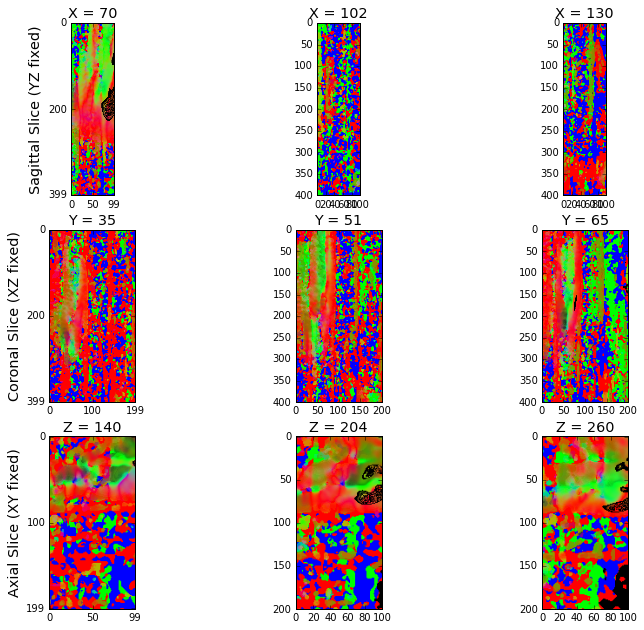

In [23]:
fig = plot_rgb(im)

In [24]:
from dipy.tracking.eudx import EuDX

In [28]:
print FA.shape

(200, 100, 400, 3)


In [14]:
def tensor2tract(struct_tensor, is_fsl):
    if is_fsl:
        tmp = np.copy(struct_tensor[:,:,:,3])
        struct_tensor[:,:,:,3] = struct_tensor[:,:,:,2]
        struct_tensor[:,:,:,2] = tmp
    output = from_lower_triangular(struct_tensor)
    output = output[300:500, 250:350, 400:800, :, :]

    
    evals, evecs = decompose_tensor(output)

    FA = fractional_anisotropy(evals)

    RGB = color_fa(FA, evecs)
    # nb.save(nb.Nifti1Image(np.array(255 * RGB, 'uint8'), result.get_affine()), 'fsl_tensor_rgb_upper.nii.gz')

    #affine = struct_tensor.get_affine()
    fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
    im = fa.get_data()

    fig = plot_rgb(im)
    plt.savefig('tensor_field_brain.png')


    sphere = get_sphere('symmetric724')
    peak_indices = quantize_evecs(evecs, sphere.vertices)
    eu = EuDX(FA.astype('f8'), peak_indices, seeds=50000, odf_vertices = sphere.vertices, a_low=0.2)
    tensor_streamlines = [streamline for streamline in eu]
    return tensor_streamlines

(400, 100, 3)
(400, 100, 3)
(400, 100, 3)
(400, 200, 3)
(400, 200, 3)
(400, 200, 3)
(200, 100, 3)
(200, 100, 3)
(200, 100, 3)


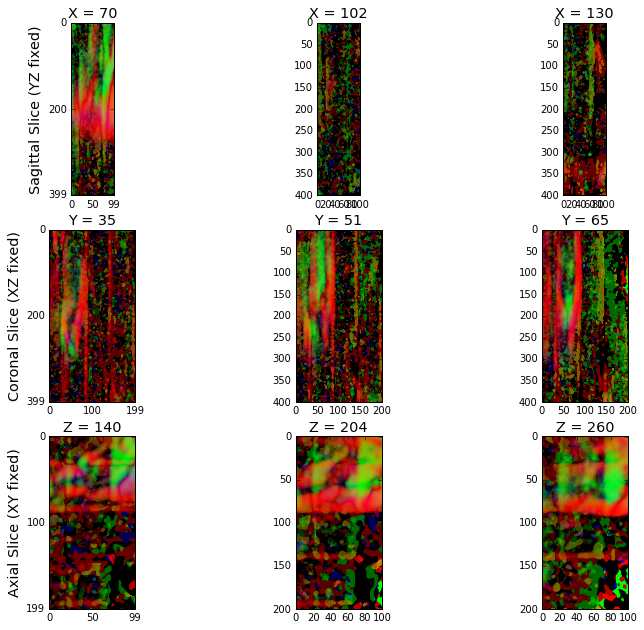

In [18]:
affine = img.affine

tensorimg = np.load('tensorimage.npy')
streamlines = tensor2tract(tensorimg, False)

In [102]:
np.savez('neweststreams', streamlines)

In [119]:
graphel = !python multigraphs.py neweststreams.npz hello/ Fear199ImageLddmmABALabels.img

In [120]:
g = nx.adj_matrix(graphel).todense()
fig = plt.figure(figsize=(7,7))
p = plt.imshow(g, interpolation='None')

AttributeError: 'SList' object has no attribute 'number_of_edges'

In [114]:
import networkx as nx
#'/home/graph.graphml'
path = '/home/hello/graphs/Fear199ImageLddmmABALabels/neweststreams_Fear199ImageLddmmABALabels.gpickle'

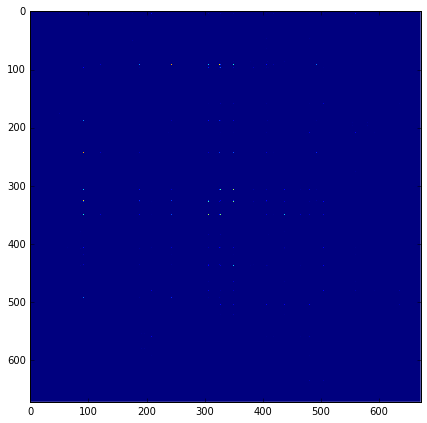

In [116]:
g = nx.read_gpickle(path)
g = nx.adj_matrix(g).todense()
fig = plt.figure(figsize=(7,7))
p = plt.imshow(g, interpolation='None')

In [64]:
pwd

u'/home'

In [59]:
data = np.load('aut1374streamlines.npy')
np.savez('aut1374streamlines', data)

In [19]:
np.save('aut1374streamlines', streamlines)

In [20]:
from dipy.tracking.eudx import EuDX
from dipy.reconst import peaks, shm
from dipy.tracking import utils

In [27]:
from dipy.data import read_stanford_labels, fetch_stanford_t1, read_stanford_t1

hardi_img, gtab, labels_img = read_stanford_labels()
data = hardi_img.get_data()
labels = labels_img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/stanford_hardi 


In [31]:
print data.shape

(81, 106, 76, 160)


In [28]:
print labels.shape

(81, 106, 76)


In [34]:
labels = img.get_data()
print labels.shape

(768, 576, 1358, 1)


In [35]:
print streamlines

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [53]:
from argparse import ArgumentParser
from datetime import datetime
from subprocess import Popen, PIPE
import os.path as op
import nibabel as nb
import ndmg.graph as mgg
import ndmg.utils as mgu
import numpy as np

def multigraphs(fibers, labels, outdir):
    """
    Creates a brain graph from fiber streamlines
    """
    startTime = datetime.now()

    # Load fibers
    print "Loading fibers..."
    fiber_npz = fibers
    #tracks = fiber_npz[fiber_npz.keys()[0]]
    tracks = fiber_npz

    # Generate graphs from streamlines for each parcellation
    for idx, label in enumerate(labels):
        #print "Generating graph for " + label + " parcellation..."
        labels_im = nb.load(labels[idx])
        g1 = mgg(len(np.unique(labels_im.get_data()))-1, labels[idx])
        g1.make_graph(tracks)
        g1.summary()
        g1.save_graph(graphs[idx])

    print "Execution took: " + str(datetime.now() - startTime)
    print "Complete!"
    pass

In [56]:
multigraphs(streamlines, img.get_data(), outdir="./")

Loading fibers...


TypeError: coercing to Unicode: need string or buffer, memmap found

In [39]:
cc_slice = labels == 2
cc_streamlines = utils.target(streamlines, cc_slice, affine=affine)
cc_streamlines = list(cc_streamlines)

other_streamlines = utils.target(streamlines, cc_slice, affine=affine,
                                 include=False)
other_streamlines = list(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

ValueError: streamlines points are outside of target_mask

In [135]:
def generate_FSL_and_DTK_structure_tensor_test(img_data, filename, dogsigmaArr=[1], gausigmaArr=[0.5], angleArr=[25]):
    """
    Function takes a numpy array (from TIFF_stack_to_array) and saves output
    FSL/DTK structure tensors as filename string. Allows inputting alternate dogsigmaArr,
    gausigmaArr, angleArr, although defaults to currently to parameters from MATLAB script.
    Also returns tensorfsl / tensorDTK (the tensor fsl/DTK structure) image numpy arrays.

    ## Parameters (the script loops through all parameters and saves each result automatically)
    # dogsigmaArr = [1]; Sigma values for derivative of gaussian filter, recommended value: 0.6 - 1.3 (based on actual data)
    # gausigmaArr = [2.3]; Sigma values for gaussian filter, recommended value: 1.3 - 2.3 (based on actual data)
    # angleArr = [25]; Angle thresholds for fiber tracking, recommended value: 20 - 30.

    Follows code from MATLAB CAPTURE scripts.

    :param img_data: Numpy array of image, typically from tiff_stack_to_array called on a directory of TIFFs.
    :param filename: Name to save the FSL structure tensor as.
    :param dogsigmaArr: Sigma values for derivative of Gaussian filter, with recommended values between 0.6 - 1.3.
    :param gausigmaArr: Sigma values for Gaussian filter, with recommended values between 1.3 - 2.3. (?)
    :param angleArr: Angle threshold for fiber tracking, with recommended values between 20 - 30. (?)
    :return tensorfsl: TensorFSL format of structure tensor (upper triangular matrix)
    :return tensordtk: TensorDTK format of structure tensor (upper triangular matrix)
    """
    
    # Helper function similar to MATLAB
    def cropvol(vol, sz):
        print np.size(vol);
        vol[0:sz, :, :, :] = 0;
        vol[-1-sz+1:-1, :, :, :] = 0;

        vol[:, 0:sz, :, :] = 0;
        vol[:, -1-sz+1:-1, :, :] = 0;

        vol[:, :, 0:sz, :] = 0;
        vol[:, :, -1-sz+1:-1, :] = 0;
        return vol;
    
    for ii in range(len(dogsigmaArr)):
        dogsigma = dogsigmaArr[ii];
        print "Start DoG Sigma on " + str(dogsigma);

        # Generate dog kernels
        dogkercc = doggen([dogsigma, dogsigma, dogsigma]);
        dogkercc = np.transpose(dogkercc, (0, 2, 1));  # annoying

        #print dogkercc.shape;
        print dogkercc[:, :, 0];

        dogkerrr = np.transpose(dogkercc, (1, 0, 2));

        #print dogkerrr[:, :, 0];
        dogkerzz = np.transpose(dogkercc, (0, 2, 1));

        #print dogkerzz[:, :, 0];

        for jj in range(len(gausigmaArr)):
            gausigma = gausigmaArr[jj];
  
            print "Start Gauss Sigma with gausigma = " + str(gausigma);

            print "Generating Gaussian kernel..."
            gaussker = np.single(gaussgen([gausigma, gausigma, gausigma]));

            # Generate half size kernel
            halfsz = (max(len(dogkercc), len(gaussker)) + 1) / 2;

            # Compute gradients
            grr = signal.convolve(img_data, dogkerrr, 'same');

            #print grr[:, :, 0];

            gcc = signal.convolve(img_data, dogkercc, 'same');

            #print gcc[:, :, 0];

            gzz = signal.convolve(img_data, dogkerzz, 'same');

            #print gzz[:, :, 0];

            # Compute gradient products
            gprrrr = np.multiply(grr, grr);

            #print gprrrr[:, :, 0];

            gprrcc = np.multiply(grr, gcc);

            #print gprrcc[:, :, 0];

            gprrzz = np.multiply(grr, gzz);

            #print gprrzz[:, :, 0]

            gpcccc = np.multiply(gcc, gcc);
            gpcczz = np.multiply(gcc, gzz);
            gpzzzz = np.multiply(gzz, gzz);

            # Compute gradient amplitudes
            # print ga.dtype;
            ga = np.sqrt(gprrrr + gpcccc + gpzzzz);

            #print ga[:, :, 0];

            #print "GA SHAPE:"
            #print ga.shape;

            # Convert numpy ndarray object to Nifti data type
            gradient_amplitudes_data = nib.Nifti1Image(ga, affine=np.eye(4));

            # Save gradient amplitudes image 
            nib.save(gradient_amplitudes_data, 'gradient_amplitudes.nii.gz');

            # Compute gradient vectors
            gv = np.concatenate((grr[..., np.newaxis], gcc[..., np.newaxis], gzz[..., np.newaxis]), axis = 3);
            
            #print gv[:, :, 0, 0];
            
            gv = np.divide(gv, np.tile(ga[..., None], [1, 1, 1, 3]));
            #print gv[:, :, 0, 1];

            #print "GV SHAPE:"
            #print gv.shape;

            # Convert numpy ndarray object to Nifti data type
            gradient_vectors_data = nib.Nifti1Image(gv, affine=np.eye(4));

            # Save gradient vectors
            nib.save(gradient_vectors_data, 'gradient_vectors.nii.gz');

            #print gaussker[:, :, 0];

            print "Blurring gradient products..."
            gprrrrgauss = signal.convolve(gprrrr, gaussker, "same");
            
            #print gprrrrgauss[:, :, 0];
            
            gprrccgauss = signal.convolve(gprrcc, gaussker, "same");
            
            #print gprrccgauss[:, :, 0];
            
            gprrzzgauss = signal.convolve(gprrzz, gaussker, "same");
            gpccccgauss = signal.convolve(gpcccc, gaussker, "same");
            gpcczzgauss = signal.convolve(gpcczz, gaussker, "same");
            gpzzzzgauss = signal.convolve(gpzzzz, gaussker, "same");

            print "Saving a copy for this Gaussian sigma..."
            tensorfsl = np.concatenate((gprrrrgauss[..., np.newaxis], gprrccgauss[..., np.newaxis], gprrzzgauss[..., np.newaxis], gpccccgauss[..., np.newaxis], gpcczzgauss[..., np.newaxis], gpzzzzgauss[..., np.newaxis]), axis = 3);
            
            tensordtk = np.concatenate((gprrrrgauss[..., np.newaxis], gprrccgauss[..., np.newaxis], gpccccgauss[..., np.newaxis], gprrzzgauss[..., np.newaxis], gpcczzgauss[..., np.newaxis], gpzzzzgauss[..., np.newaxis]), axis = 3);

             # Convert numpy ndarray object to Nifti data type
            tensor_fsl_data = nib.Nifti1Image(cropvol(tensorfsl, halfsz), affine=np.eye(4));
            tensor_dtk_data = nib.Nifti1Image(cropvol(tensordtk, halfsz), affine=np.eye(4));

            nib.save(tensor_fsl_data, str(filename) + "dogsigma_" + str(dogsigma) + "gausigma_" + str(gausigma) + 'tensorfsl.nii.gz');
            nib.save(tensor_dtk_data, str(filename) + "dogsigma_" + str(dogsigma) + "gausigma_" + str(gausigma) + 'tensordtk.nii.gz');

    print 'Completed computing structure tensor on ' + str(filename) + '!'
    return tensorfsl, tensordtk

In [136]:
tensordata = nib.load('v571.nii')

In [137]:
print type(tensordata.get_data())

<class 'numpy.core.memmap.memmap'>


In [138]:
fslstruct = generate_FSL_and_DTK_structure_tensor(img_data = tensordata.get_data(), filename = 'demofsl', dogsigmaArr=[1], gausigmaArr=[0.5], angleArr=[25])

Start DoG Sigma on 1
Start Gauss Sigma with gausigma = 0.5
Generating Gaussian kernel...
Blurring gradient products...
Saving a copy for this Gaussian sigma...
Completed computing structure tensor on demofsl!


In [21]:
structure = fear199tensor[0]

In [22]:
def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :], 90)
            else:
                image = im[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig

In [23]:
print structure.shape

(576, 1358, 6)


In [24]:
data = structure
print data.shape

(576, 1358, 6)


In [25]:
output = from_lower_triangular(data)
print output.shape

(576, 1358, 3, 3)


In [26]:
FA = fractional_anisotropy(output)
FA = np.clip(FA, 0, 1)
FA[np.isnan(FA)] = 0
print FA.shape

(576, 1358, 3)


/usr/local/lib/python2.7/dist-packages/dipy/reconst/dti.py:108: RuntimeWarning: invalid value encountered in true_divide
  ((evals * evals).sum(0) + all_zero))
/usr/local/lib/python2.7/dist-packages/dipy/reconst/dti.py:108: RuntimeWarning: invalid value encountered in sqrt
  ((evals * evals).sum(0) + all_zero))


In [27]:
evalues, evectors = decompose_tensor(output)
print evectors[..., 0, 0].shape
print evectors.shape[-2:]

(576, 1358)
(3, 3)


In [31]:
RGB = color_fa(FA[:, :, :, 0], evectors)

IndexError: too many indices for array

In [ ]:
#nib.save(nib.Nifti1Image(np.array(255 * RGB, 'uint8'), img.get_affine()), 'tensor_rgb_upper_albert.nii.gz')

In [159]:
affine = img.get_affine()

fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
im = fa.get_data()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  """Entry point for launching an IPython kernel.


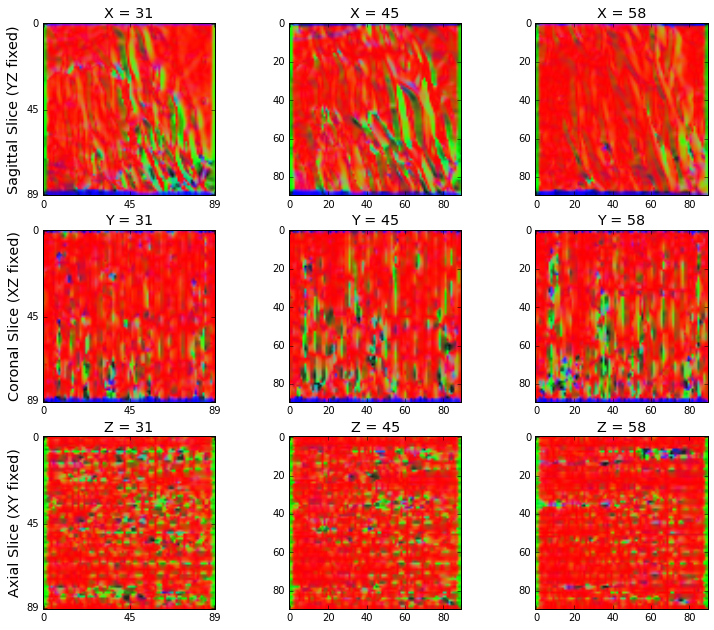

In [160]:
fig = plot_rgb(im)